<a href="https://colab.research.google.com/github/huhjayeon/cbm-prediction-model/blob/main/cbm_prediction_Xgboost_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CBM 예측 - Xgboost Model

Fitting 3 folds for each of 50 candidates, totalling 150 fits

RandomizedSearchCV 최적 하이퍼파라미터: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
RandomizedSearchCV 최적 Mean Absolute Error (MAE): 0.09

테스트 데이터 MAE: 0.09
테스트 데이터 RMSE: 0.82



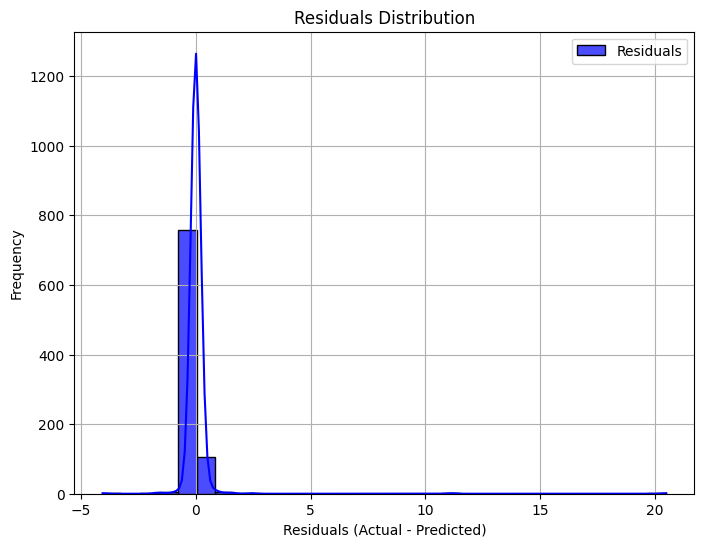

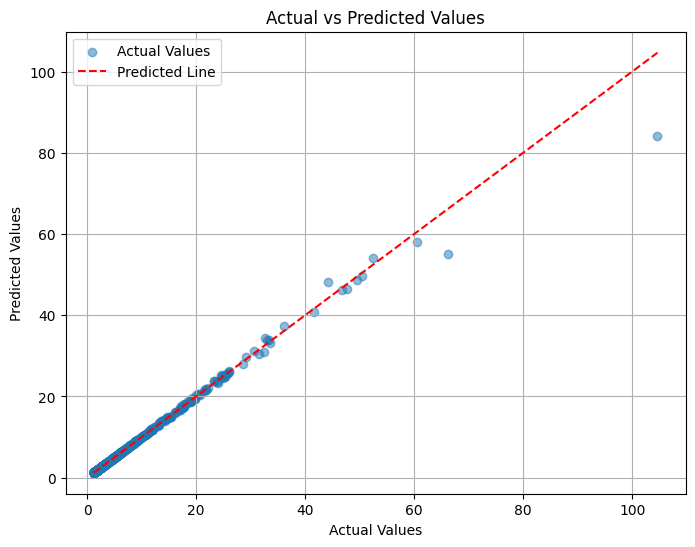

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

import numpy as np

# 데이터 로드
pckg_cbm = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/cms/data/cbm/tb_pckg_cbm_fin.csv')
pckg_prod = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/cms/data/cbm/tb_pckg_prod_fin.csv')

# 데이터 전처리
# SKU 종류와 수량 계산
sku_count = pckg_prod.groupby('pckg_no')['prod_cd'].nunique().reset_index()
sku_count.rename(columns={'prod_cd': 'sku_count'}, inplace=True)

total_qty = pckg_prod.groupby('pckg_no')['qty'].sum().reset_index()
total_qty.rename(columns={'qty': 'total_qty'}, inplace=True)

# SKU 총 부피 계산
sku_total_volume = pckg_prod.groupby('pckg_no')['total_prod_volume'].sum().reset_index()
sku_total_volume.rename(columns={'total_prod_volume': 'sku_total_volume'}, inplace=True)

# 패킹 데이터와 병합
pallet_total_cbm = pckg_cbm[['pckg_no', 'total_pckg_cbm']].drop_duplicates()
merged_data = pd.merge(sku_total_volume, pallet_total_cbm, on='pckg_no')
merged_data = pd.merge(merged_data, sku_count, on='pckg_no')
merged_data = pd.merge(merged_data, total_qty, on='pckg_no')

# 팔레트 높이 추가
merged_data['pallet_height'] = merged_data['total_pckg_cbm'] / (1.1 * 1.1)  # 가로와 세로는 1.1m 고정

# 패킹넘버별 팔레트 개수 계산
pallet_counts = pckg_cbm.groupby('pckg_no').size().reset_index(name='pallet_count')

# 팔레트 개수와 최대 가능한 부피 계산
pallet_counts['max_possible_cbm'] = pallet_counts['pallet_count'] * (1.1 * 1.1 * 2.4)  # 1.1m x 1.1m x 2.4m

# 패킹 데이터와 병합
merged_with_counts = pd.merge(merged_data, pallet_counts, on='pckg_no')

# 이상치 탐지 (실제 total_pckg_cbm > max_possible_cbm)
outliers = merged_with_counts[merged_with_counts['total_pckg_cbm'] > merged_with_counts['max_possible_cbm']]

# 이상치 제거
filtered_data = merged_with_counts[merged_with_counts['total_pckg_cbm'] <= merged_with_counts['max_possible_cbm']]

# 독립 변수와 종속 변수 설정
X = filtered_data[['sku_total_volume', 'sku_count', 'total_qty', 'pallet_height']]
y = filtered_data['total_pckg_cbm']

# 하한값 설정 (y > 1.21)
lower_bound = 1.21
valid_indices = y[y > lower_bound].index
X = X.loc[valid_indices]
y = y.loc[valid_indices]

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# XGBoost 하이퍼파라미터 튜닝
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = XGBRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# 모델 학습
random_search.fit(X_train, y_train)

# 최적 하이퍼파라미터 및 성능 출력
best_params_random = random_search.best_params_
best_score_random = -random_search.best_score_
print('')
print("RandomizedSearchCV 최적 하이퍼파라미터:", best_params_random)
print(f"RandomizedSearchCV 최적 Mean Absolute Error (MAE): {best_score_random:.2f}")
print('')

# 최적 모델로 테스트 데이터 예측
best_model = random_search.best_estimator_
y_test_pred = best_model.predict(X_test)

# 테스트 데이터 평가
mae = mean_absolute_error(y_test, y_test_pred)
rmse = root_mean_squared_error(y_test, y_test_pred)

print(f"테스트 데이터 MAE: {mae:.2f}")
print(f"테스트 데이터 RMSE: {rmse:.2f}")
print('')

# 시각화: 잔차 분포
residuals = y_test - y_test_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='blue', alpha=0.7, label="Residuals")
plt.title("Residuals Distribution")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

# 시각화: 실제값 vs 예측값
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, label="Actual Values")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Predicted Line")
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid()
plt.show()
print('')
print('')

##교차검증 K-fold Cross Validation
교차 검증을 통해 성능이 일관 되게 좋은지 안정성 확인  

K번의 MAE 점수를 출력하고 평균 MAE를 계산하여 모델의 성능을 평가

In [6]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# XGBoost 모델 정의
xgb_model = XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.1, random_state=42)

# K-fold 설정 (K=5 예시)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross Validation 수행 (MAE로 평가)
cv_scores = cross_val_score(xgb_model, X, y, cv=kfold, scoring='neg_mean_absolute_error')

# 결과 출력
print('')
print(f"Cross-Validation MAE Scores: {-cv_scores}")
print(f"Average MAE: {-np.mean(cv_scores):.2f}")



Cross-Validation MAE Scores: [0.10422114 0.11029797 0.10820302 0.13592375 0.10741351]
Average MAE: 0.11


K-fold Cross Validation(5-fold)을 통해 평균 MAE 값 0.11 기록.  

모델이 안정적으로 학습되었고, 성능이 K번의 평가에서도 일관적이라는 것을 의미.